In [50]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats as sp_stats
from scipy import signal
from itertools import product

warnings.filterwarnings('ignore')

RV_window = 5 # Weekly Realized Volatility window

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


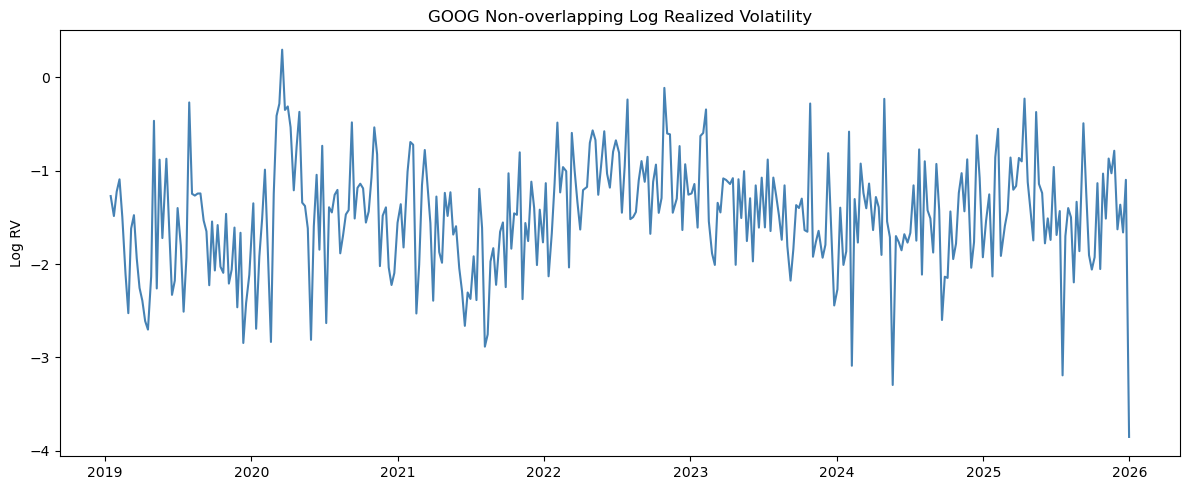

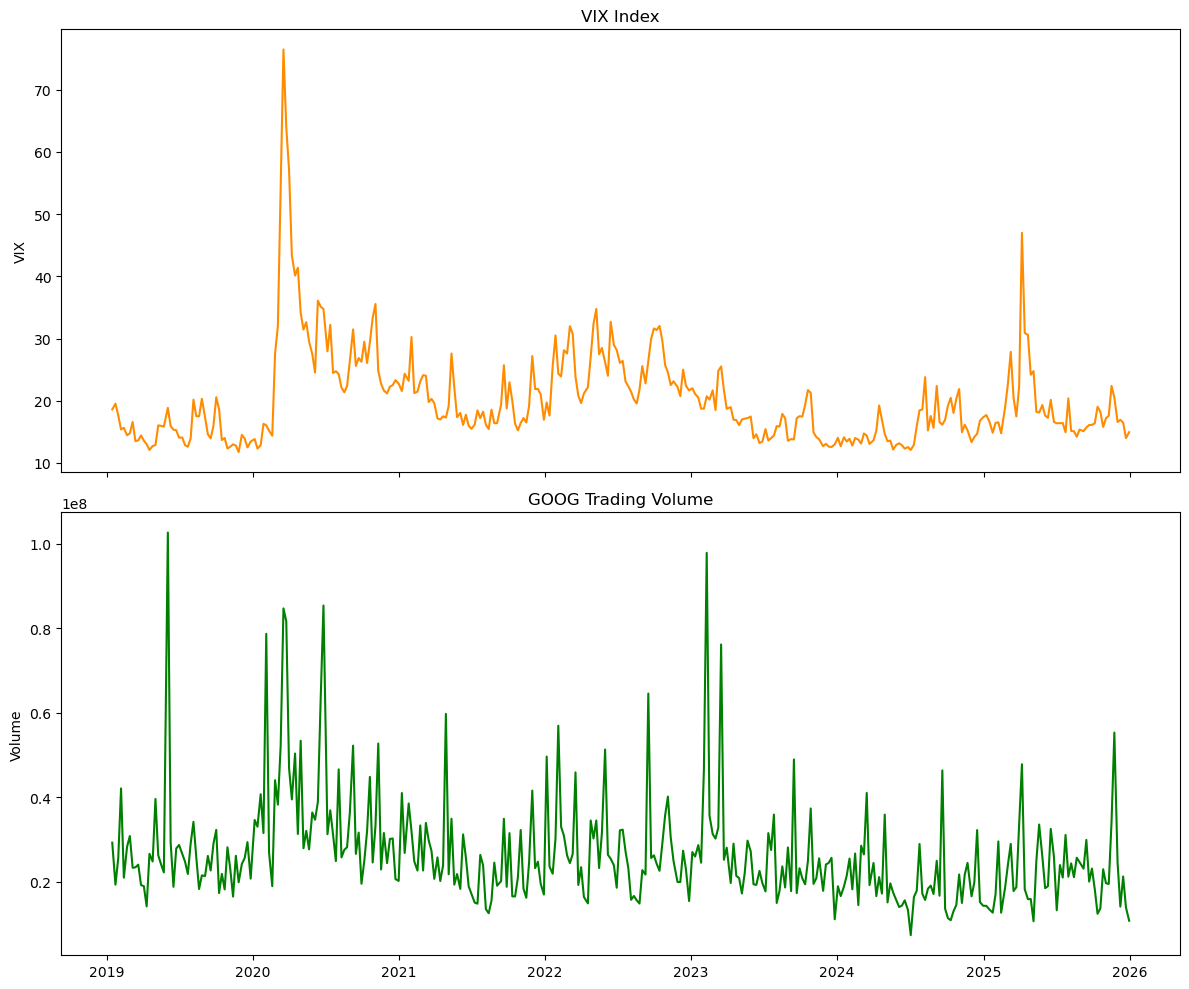

In [51]:
# Downloading data, feature engineering, and plotting

goog_df = yf.download('GOOG', start='2019-01-01', end='2026-01-01')
goog_df.index = pd.to_datetime(goog_df.index)
goog_df = goog_df.sort_index(ascending=True)

vix_df = yf.download('^VIX', start='2019-01-01', end='2026-01-01')
vix_df.index = pd.to_datetime(vix_df.index)
vix_df = vix_df.sort_index(ascending=True)

close_df = goog_df[['Close']].copy()
close_df.columns = ['Close']
close_df['Volume'] = goog_df['Volume'].values
close_df = close_df.reset_index().rename(columns={"Date": "date"})

vix_close = vix_df[['Close']].copy()
vix_close.columns = ['VIX']
vix_close = vix_close.reset_index().rename(columns={"Date": "date"})

rv_df = close_df.copy()
rv_df['Log_return'] = np.log(rv_df['Close'] / rv_df['Close'].shift(1))

def get_RV(row, log_returns):
    idx = log_returns.index.get_loc(row.name)
    if idx < RV_window - 1:
        return np.nan
    window_returns = log_returns.iloc[idx - RV_window + 1 : idx + 1]
    return window_returns.std() * np.sqrt(252)

rv_df['RV'] = rv_df.apply(get_RV, axis=1, log_returns=rv_df['Log_return'])
rv_df = rv_df.dropna(subset=['RV']).reset_index(drop=True)
rv_df['Log_RV'] = np.log(rv_df['RV'])

logrv_no_overlap_df = rv_df.iloc[RV_window::RV_window].reset_index(drop=True)

logrv_no_overlap_df = logrv_no_overlap_df.merge(vix_close, on='date', how='left')
logrv_no_overlap_df['VIX'] = logrv_no_overlap_df['VIX'].ffill()

plt.figure(figsize=(12, 5))
axes = plt.gca()
axes.plot(logrv_no_overlap_df['date'], logrv_no_overlap_df['Log_RV'], color='steelblue')
axes.set_ylabel('Log RV')
axes.set_title('GOOG Non-overlapping Log Realized Volatility')
plt.tight_layout()
plt.savefig('plot/log_realized_volatility_google.png')
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
axes[0].plot(logrv_no_overlap_df['date'], logrv_no_overlap_df['VIX'], color='darkorange')
axes[0].set_ylabel('VIX')
axes[0].set_title('VIX Index')
axes[1].plot(logrv_no_overlap_df['date'], logrv_no_overlap_df['Volume'], color='green')
axes[1].set_ylabel('Volume')
axes[1].set_title('GOOG Trading Volume')
plt.savefig('plot/exogenous_variables.png')
plt.tight_layout()
plt.show()


Train set: 280 obs  (2019-01-15 to 2024-08-01)
Test set:  71 obs  (2024-08-08 to 2025-12-31)


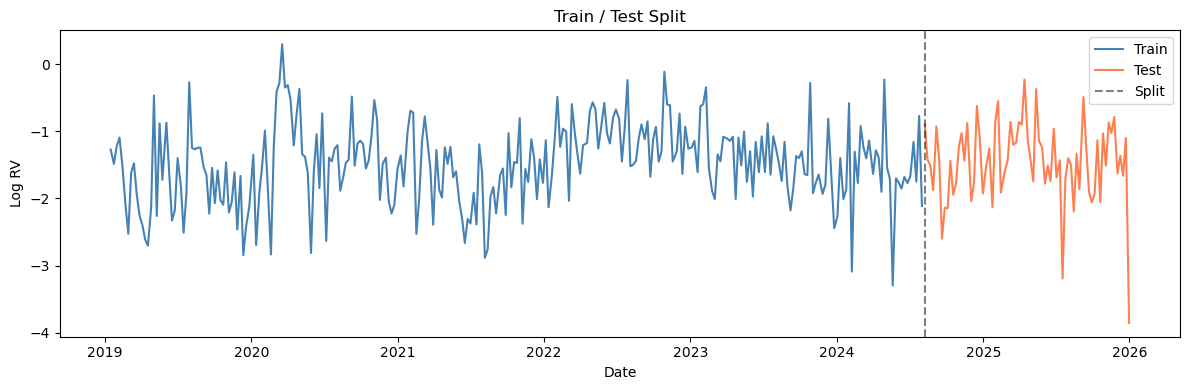

In [52]:
# Train/test split (80/20) based on time order

train_size = int(len(logrv_no_overlap_df) * 0.8)
train_df = logrv_no_overlap_df.iloc[:train_size].copy().reset_index(drop=True)
test_df = logrv_no_overlap_df.iloc[train_size:].copy().reset_index(drop=True)
y_train = train_df['Log_RV'].values
y_test = test_df['Log_RV'].values

print(f"Train set: {len(train_df)} obs  ({train_df['date'].iloc[0].date()} to {train_df['date'].iloc[-1].date()})")
print(f"Test set:  {len(test_df)} obs  ({test_df['date'].iloc[0].date()} to {test_df['date'].iloc[-1].date()})")

plt.figure(figsize=(12, 4))
plt.plot(train_df['date'], train_df['Log_RV'], label='Train', color='steelblue')
plt.plot(test_df['date'], test_df['Log_RV'], label='Test', color='coral')
plt.axvline(x=test_df['date'].iloc[0], color='black', linestyle='--', alpha=0.5, label='Split')
plt.title('Train / Test Split')
plt.savefig('plot/train_test_split.png')
plt.xlabel('Date'); plt.ylabel('Log RV')
plt.legend(); plt.tight_layout(); plt.show()

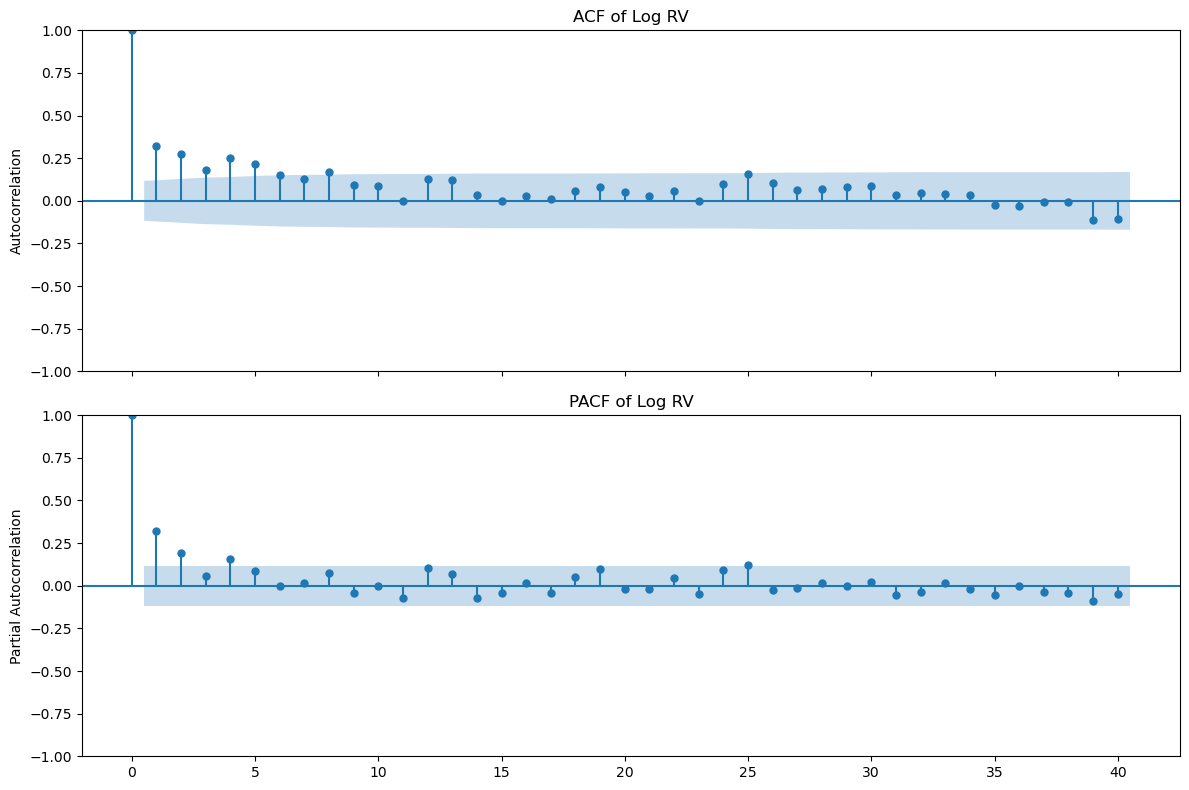

In [53]:
# ACF, PACF plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_acf(train_df['Log_RV'], lags=40, ax=axes[0], title='ACF of Log RV')
axes[0].set_ylabel('Autocorrelation')
plot_pacf(train_df['Log_RV'], lags=40, ax=axes[1], title='PACF of Log RV')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig('plot/acf_pacf.png')
plt.show()

In [54]:
# ADF test
result = adfuller(train_df['Log_RV'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.315268328604967
p-value: 5.090668508813624e-06


In [55]:
# KPSS test 
kpss_p, _, _, _ = kpss(train_df['Log_RV'], regression='c') 
print(f"KPSS p-value: {kpss_p:.4f}")

KPSS p-value: 0.3090


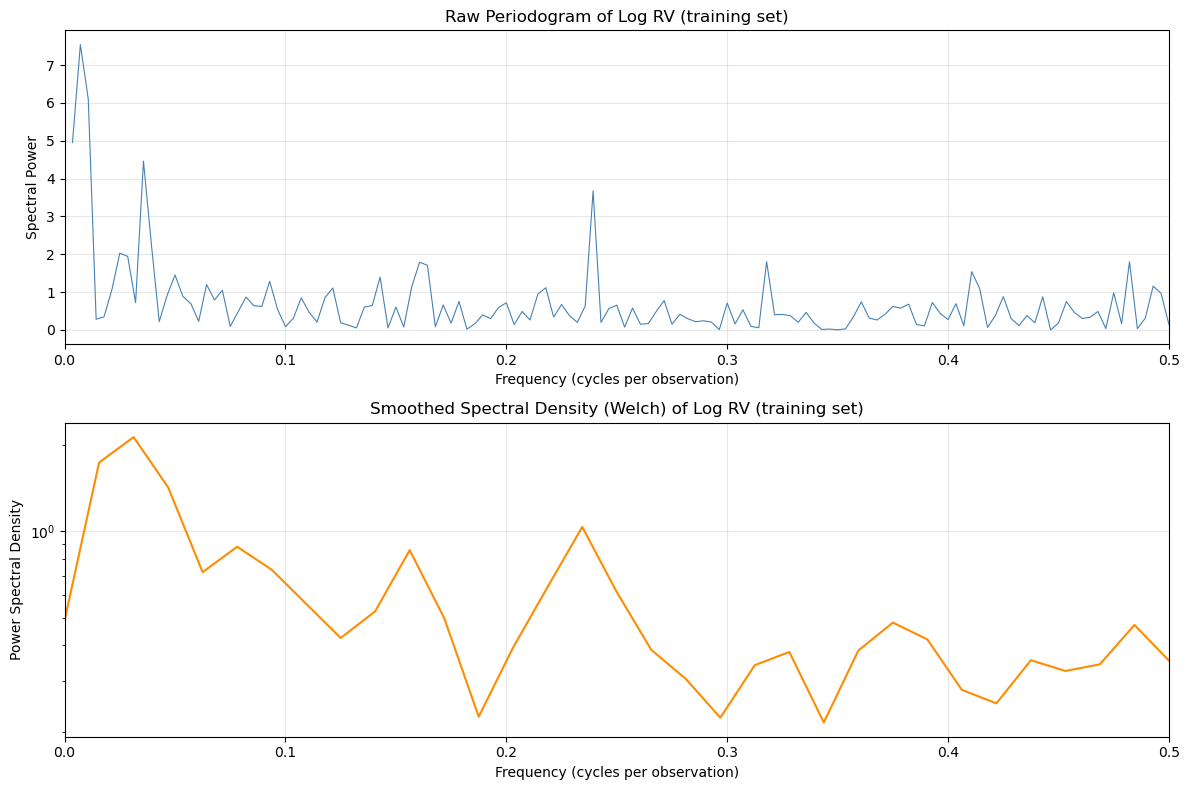

Dominant frequency after 0.04: 0.2393 cycles/obs
Dominant period: 4.2 observations (~4 weeks)


In [56]:
y_train = train_df['Log_RV'].values
n = len(y_train)

# Raw periodogram via FFT
fft_vals = np.fft.rfft(y_train - np.mean(y_train))
freqs_raw = np.fft.rfftfreq(n, d=1.0)
periodogram_raw = (2.0 / n) * np.abs(fft_vals) ** 2

# Smoothed spectral density via Welch's method
freqs_welch, psd_welch = signal.welch(y_train, fs=1.0, nperseg=min(64, n // 4))

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Raw periodogram
axes[0].plot(freqs_raw[1:], periodogram_raw[1:], color='steelblue', linewidth=0.8)
axes[0].set_title('Raw Periodogram of Log RV (training set)')
axes[0].set_xlabel('Frequency (cycles per observation)')
axes[0].set_ylabel('Spectral Power')
axes[0].set_xlim(0, 0.5)
axes[0].grid(True, alpha=0.3)

# Smoothed spectral density (Welch)
axes[1].semilogy(freqs_welch, psd_welch, color='darkorange', linewidth=1.5)
axes[1].set_title('Smoothed Spectral Density (Welch) of Log RV (training set)')
axes[1].set_xlabel('Frequency (cycles per observation)')
axes[1].set_ylabel('Power Spectral Density')
axes[1].set_xlim(0, 0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot/periodogram_and_spectral_density.png')
plt.show()

# We want to find the dominant frequency for frequencies greater than 1/28 (we want frequencies that will occur more than 10 times), 
# peaks before that can be attributed to low-frequency persistence. However, we proceed with caution using a period of 4
# The low frequency peaks might be insignificant because very few cycles are observed in the dataset 
mask = freqs_raw > 1/28
peak_idx = np.where(mask)[0][np.argmax(periodogram_raw[mask])]
peak_freq = freqs_raw[peak_idx]
peak_period = 1.0 / peak_freq if peak_freq > 0 else np.inf

print(f"Dominant frequency after 0.04: {peak_freq:.4f} cycles/obs")
print(f"Dominant period: {peak_period:.1f} observations (~{peak_period:.0f} weeks)")

In [57]:
# ARIMA(p,0,q) grid search based on AIC

arima_results = []
for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(y_train, order=(p, 0, q))
            res = model.fit()
            arima_results.append({'p': p, 'q': q, 'AIC': res.aic})
        except Exception:
            pass

arima_aic_df = pd.DataFrame(arima_results).sort_values('AIC').reset_index(drop=True)
print(arima_aic_df.head(10).to_string(index=False))

 p  q        AIC
 3  3 459.326834
 5  3 464.334023
 3  5 464.827442
 4  4 465.038998
 4  3 465.342628
 1  1 465.923623
 5  4 466.980502
 5  5 467.062606
 4  5 467.332411
 2  1 467.742901


In [58]:
# SARIMA(p,0,q)(P,0,Q)_4 grid search based on AIC
# Using s=4 based on the dominant period from the spectral analysis

sarima_results = []
for p, q, P, Q in product(range(4), range(4), range(2), range(2)):
    try:
        model = SARIMAX(y_train, order=(p, 0, q), seasonal_order=(P, 0, Q, 4),
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=200)
        sarima_results.append({'p': p, 'q': q, 'P': P, 'Q': Q, 'AIC': res.aic})
    except Exception:
        pass

sarima_aic_df = pd.DataFrame(sarima_results).sort_values('AIC').reset_index(drop=True)
print(sarima_aic_df.head(10).to_string(index=False))

 p  q  P  Q        AIC
 1  3  0  1 463.202368
 3  3  0  1 463.337099
 1  3  1  1 464.159906
 3  3  1  0 464.278003
 2  3  0  1 465.039958
 2  3  1  1 466.159904
 3  1  1  0 466.350331
 1  2  0  1 467.104348
 2  1  1  0 467.275543
 2  1  0  1 467.336175


In [59]:
# SARIMAX with exogenous variables grid search based on AIC
# Using s=4 based on the dominant period from the spectral analysis
# We will test three exogenous regressors: VIX only, Volume only, and VIX+Volume

exog_configs = {
    'VIX': train_df[['VIX']],
    'Volume': train_df[['Volume']],
    'VIX+Volume': train_df[['VIX', 'Volume']],
}

sarimax_results = []
for exog_name, exog_data in exog_configs.items():
    for p, q, P, Q in product(range(4), range(4), range(2), range(2)):
        try:
            model = SARIMAX(y_train, exog=exog_data.values,
                            order=(p, 0, q), seasonal_order=(P, 0, Q, 4),
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False, maxiter=200)
            sarimax_results.append({
                'exog': exog_name, 'p': p, 'q': q, 'P': P, 'Q': Q, 'AIC': res.aic
            })
        except Exception:
            pass

sarimax_aic_df = pd.DataFrame(sarimax_results).sort_values('AIC').reset_index(drop=True)

for name in exog_configs:
    subset = sarimax_aic_df[sarimax_aic_df['exog'] == name].head(5)
    print(f"{name}")
    print(subset.to_string(index=False))

VIX
exog  p  q  P  Q        AIC
 VIX  3  3  0  1 403.277839
 VIX  3  3  1  0 404.231503
 VIX  3  3  0  0 407.829387
 VIX  1  1  0  1 409.924931
 VIX  1  3  0  1 410.805926
Volume
  exog  p  q  P  Q        AIC
Volume  1  3  0  1 721.069145
Volume  1  3  1  1 721.739456
Volume  2  3  0  1 725.869694
Volume  1  2  1  1 726.024472
Volume  1  1  1  1 726.212578
VIX+Volume
      exog  p  q  P  Q        AIC
VIX+Volume  1  3  0  0 620.593835
VIX+Volume  2  3  0  0 621.469565
VIX+Volume  3  2  0  0 623.240857
VIX+Volume  3  3  0  0 623.350789
VIX+Volume  1  1  0  0 623.686362


In [60]:
# Finding the best models in each family

arima_labelled = arima_aic_df.head(5).copy()
arima_labelled['model'] = arima_labelled.apply(
    lambda r: f"ARIMA({int(r['p'])},0,{int(r['q'])})", axis=1)
arima_labelled['family'] = 'ARIMA'

sarima_labelled = sarima_aic_df.head(5).copy()
sarima_labelled['model'] = sarima_labelled.apply(
    lambda r: f"SARIMA({int(r['p'])},0,{int(r['q'])})({int(r['P'])},0,{int(r['Q'])})_4", axis=1)
sarima_labelled['family'] = 'SARIMA'

non_exog = pd.concat([arima_labelled, sarima_labelled]).sort_values('AIC').reset_index(drop=True)

print("\nTop (S)ARIMA models:")
for i, row in non_exog.head(6).iterrows():
    print(f"  {row['model']:45s}  AIC = {row['AIC']:.2f}")

best_arima_spec = non_exog.iloc[0]

sarimax_labelled = sarimax_aic_df.head(10).copy()
sarimax_labelled['model'] = sarimax_labelled.apply(
    lambda r: f"SARIMAX({int(r['p'])},0,{int(r['q'])})({int(r['P'])},0,{int(r['Q'])})_4 [{r['exog']}]", axis=1)

print("\nTop (S)ARIMAX models:")
for i, row in sarimax_labelled.head(6).iterrows():
    print(f"  {row['model']:45s}  AIC = {row['AIC']:.2f}")

best_sarimax_spec = sarimax_aic_df.iloc[0]
best_sx_label = f"SARIMAX({int(best_sarimax_spec['p'])},0,{int(best_sarimax_spec['q'])})({int(best_sarimax_spec['P'])},0,{int(best_sarimax_spec['Q'])})_4 [{best_sarimax_spec['exog']}]"


Top (S)ARIMA models:
  ARIMA(3,0,3)                                   AIC = 459.33
  SARIMA(1,0,3)(0,0,1)_4                         AIC = 463.20
  SARIMA(3,0,3)(0,0,1)_4                         AIC = 463.34
  SARIMA(1,0,3)(1,0,1)_4                         AIC = 464.16
  SARIMA(3,0,3)(1,0,0)_4                         AIC = 464.28
  ARIMA(5,0,3)                                   AIC = 464.33

Top (S)ARIMAX models:
  SARIMAX(3,0,3)(0,0,1)_4 [VIX]                  AIC = 403.28
  SARIMAX(3,0,3)(1,0,0)_4 [VIX]                  AIC = 404.23
  SARIMAX(3,0,3)(0,0,0)_4 [VIX]                  AIC = 407.83
  SARIMAX(1,0,1)(0,0,1)_4 [VIX]                  AIC = 409.92
  SARIMAX(1,0,3)(0,0,1)_4 [VIX]                  AIC = 410.81
  SARIMAX(1,0,1)(1,0,0)_4 [VIX]                  AIC = 410.86


Diagnostics: ARIMA
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  280
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -221.663
Date:                Sat, 21 Feb 2026   AIC                            459.327
Time:                        12:46:57   BIC                            488.405
Sample:                             0   HQIC                           470.990
                                - 280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4811      0.090    -16.380      0.000      -1.658      -1.304
ar.L1         -0.2132      0.065     -3.287      0.001      -0.340      -0.086
ar.L2          0.1004      0.070 

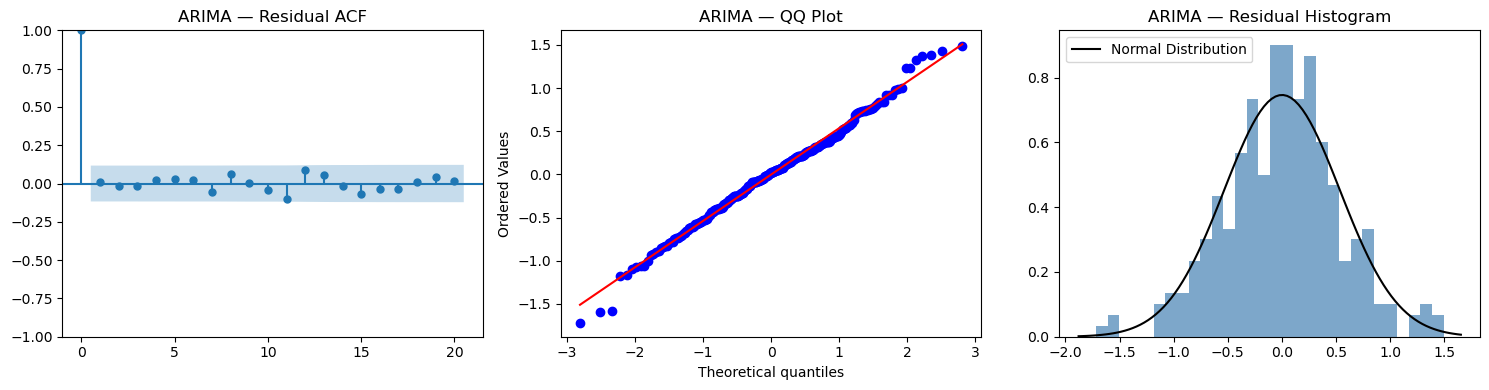

Diagnostics: SARIMAX
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  280
Model:             SARIMAX(3, 0, 3)x(0, 0, [1], 4)   Log Likelihood                -197.921
Date:                             Sat, 21 Feb 2026   AIC                            413.842
Time:                                     12:46:58   BIC                            446.294
Sample:                                          0   HQIC                           426.870
                                             - 280                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0405      0.006      7.070      0.000       0.029       0.052
ar.L1 

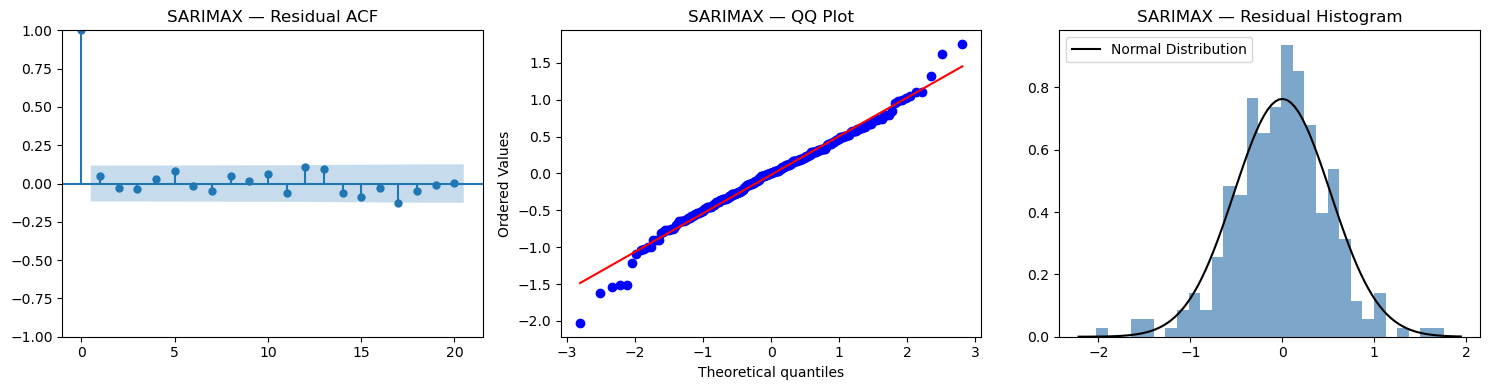

In [61]:
# Running diagnostics on the best models

def run_diagnostics(label, res):
    print(f"Diagnostics: {label}")
    print(res.summary())

    resid = res.resid

    lb = acorr_ljungbox(resid, lags=[10], return_df=True)
    print(f"\nLjung-Box (lag 10): stat = {lb['lb_stat'].values[0]:.3f}, p = {lb['lb_pvalue'].values[0]:.4f}")

    jb_stat, jb_p = sp_stats.jarque_bera(resid)[:2]
    print(f"Jarque-Bera: stat = {jb_stat:.3f}, p = {jb_p:.4f}")
    
    arch_stat, arch_p, _, _ = het_arch(resid, nlags=5)
    print(f"ARCH LM (5 lags): stat = {arch_stat:.3f}, p = {arch_p:.4f}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    plot_acf(resid, lags=20, ax=axes[0], title=f'{label} — Residual ACF')
    sp_stats.probplot(resid, dist='norm', plot=axes[1])
    axes[1].set_title(f'{label} — QQ Plot')
    axes[2].hist(resid, bins=30, density=True, alpha=0.7, color='steelblue')
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    y = sp_stats.norm.pdf(x, 0, np.std(resid))
    axes[2].plot(x, y, 'k-', label='Normal Distribution')
    axes[2].legend()
    axes[2].set_title(f'{label} — Residual Histogram')
    plt.tight_layout()
    plt.savefig(f'plot/diagnostics_{label}.png')
    plt.show()
    return res

ba = best_arima_spec
if ba['family'] == 'ARIMA':
    m1 = ARIMA(y_train, order=(int(ba['p']), 0, int(ba['q']))).fit()
else:
    m1 = SARIMAX(y_train, order=(int(ba['p']), 0, int(ba['q'])),
                 seasonal_order=(int(ba['P']), 0, int(ba['Q']), 4),
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
res_arima = run_diagnostics("ARIMA", m1)

bs = best_sarimax_spec
exog_cols = {'VIX': ['VIX'], 'Volume': ['Volume'], 'VIX+Volume': ['VIX', 'Volume']}[bs['exog']]
m2 = SARIMAX(y_train, exog=train_df[exog_cols].values,
             order=(int(bs['p']), 0, int(bs['q'])),
             seasonal_order=(int(bs['P']), 0, int(bs['Q']), 4),
             enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
res_sarimax = run_diagnostics("SARIMAX", m2)

Model 1: ARIMA
  AR root 1: -0.6318-0.8681j  |mod| = 1.0737
  AR root 2: -0.6318+0.8681j  |mod| = 1.0737
  AR root 3: 1.1326-0.0000j  |mod| = 1.1326
  MA root 1: -0.5833-0.8171j  |mod| = 1.0039
  MA root 2: -0.5833+0.8171j  |mod| = 1.0039
  MA root 3: 1.4353-0.0000j  |mod| = 1.4353
Model 2: SARIMAX
  AR root 1: 1.0006-0.0000j  |mod| = 1.0006
  AR root 2: -1.1226-1.5260j  |mod| = 1.8944
  AR root 3: -1.1226+1.5260j  |mod| = 1.8944
  MA root 1: 1.0433-0.0000j  |mod| = 1.0433
  MA root 2: 1.4912-1.4912j  |mod| = 2.1088
  MA root 3: 1.4912+1.4912j  |mod| = 2.1088
  MA root 4: -0.9527-1.4120j  |mod| = 1.7034
  MA root 5: -0.9527+1.4120j  |mod| = 1.7034
  MA root 6: -1.4912-1.4912j  |mod| = 2.1088
  MA root 7: -1.4912+1.4912j  |mod| = 2.1088


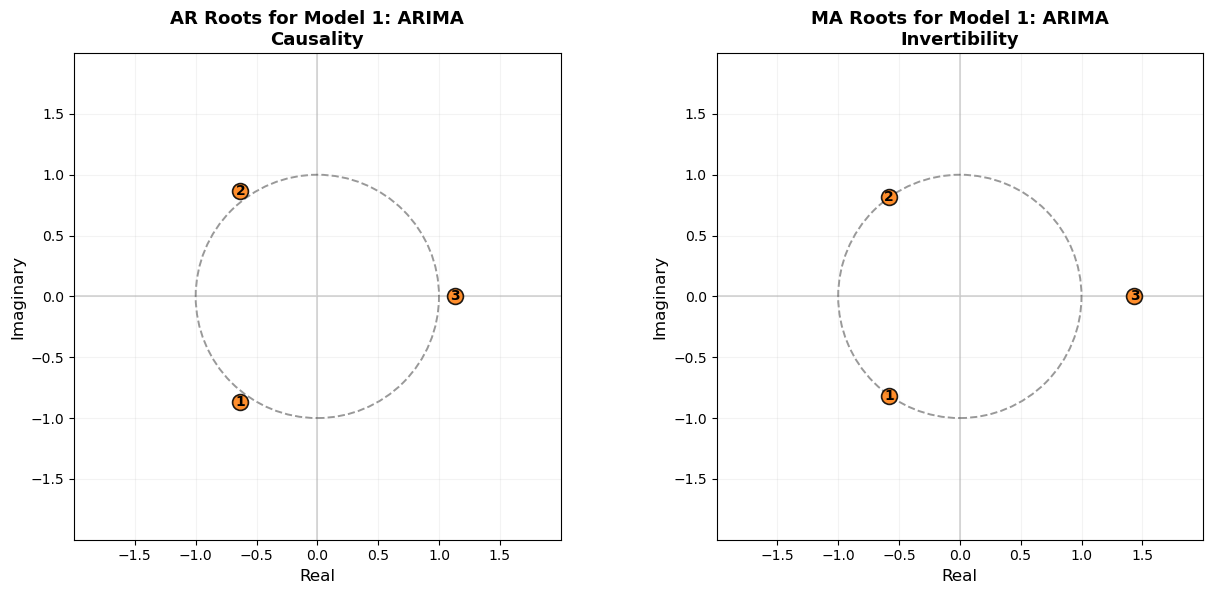

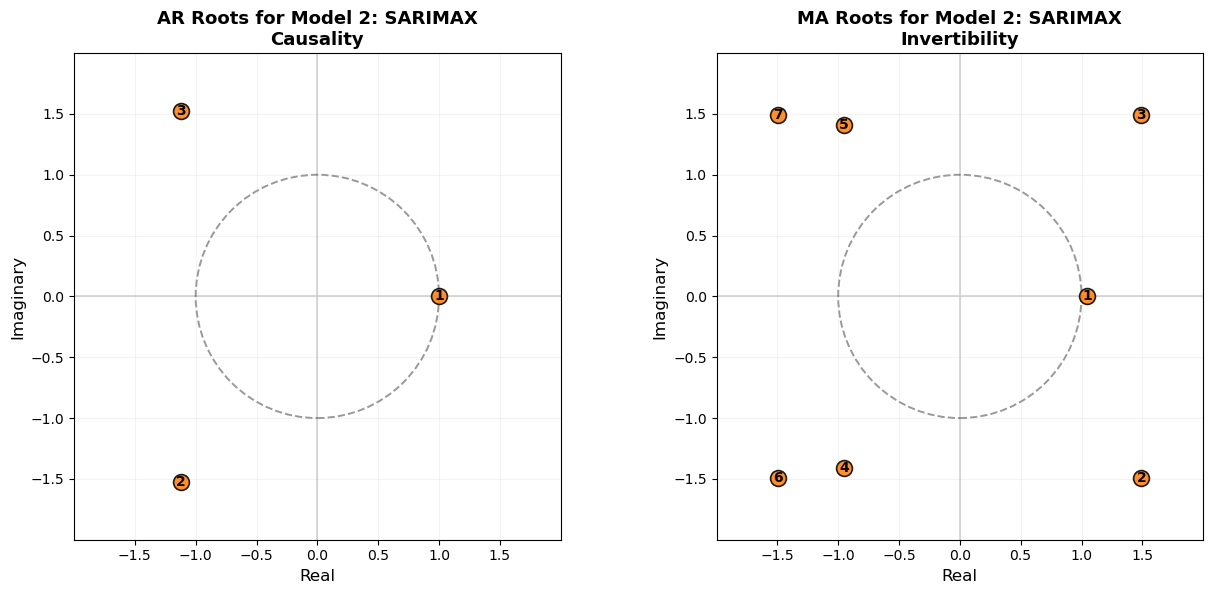

In [62]:
# Root analysis and plotting

def plot_root_circle(ar_roots, ma_roots, axs=None, label=None, color='C1', markersize=130):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(13, 6))
    elif isinstance(axs, plt.Axes):
        axs = [axs]

    def plot_roots(ax, roots, title, color):
        circle = plt.Circle((0, 0), 1, edgecolor='k', facecolor='none',
                            linestyle='--', linewidth=1.4, alpha=0.4)
        ax.add_patch(circle)

        ax.axhline(0, color='lightgrey', lw=1.2, zorder=0)
        ax.axvline(0, color='lightgrey', lw=1.2, zorder=0)

        if len(roots) > 0:
            ax.scatter(np.real(roots), np.imag(roots), c=color, s=markersize,
                        edgecolors='black', lw=1.2, alpha=0.88, zorder=5)
            for j, root in enumerate(roots):
                ax.text(np.real(root), np.imag(root), f"{j+1}", color='black',
                        fontsize=10, fontweight='bold', ha='center', va='center', zorder=6)
        else:
            ax.text(0, 0, 'No roots', fontsize=12, ha='center', va='center', color=color, alpha=0.6)

        ax.set_xlabel('Real', fontsize=12)
        ax.set_ylabel('Imaginary', fontsize=12)
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.grid(True, which='major', alpha=0.14)
        ticks = np.arange(-1.5, 1.6, 0.5)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)

    plot_roots(axs[0], ar_roots, f"AR Roots for {label}\nCausality", color)
    plot_roots(axs[1], ma_roots, f"MA Roots for {label}\nInvertibility", color)

    plt.tight_layout()
    if axs is None or not plt.fignum_exists(axs[0].figure.number):
        plt.savefig(f'plot/root_circle_{label}.png')
        plt.show()

def check_roots(res, label):
    print(f"{label}")

    ar_roots = res.arroots
    ma_roots = res.maroots

    for j, r in enumerate(ar_roots):
        mod = np.abs(r)
        print(f"  AR root {j+1}: {r:.4f}  |mod| = {mod:.4f}")

    for j, r in enumerate(ma_roots):
        mod = np.abs(r)
        print(f"  MA root {j+1}: {r:.4f}  |mod| = {mod:.4f}")

    plot_root_circle(ar_roots, ma_roots, label=label)

check_roots(res_arima, "Model 1: ARIMA")
check_roots(res_sarimax, "Model 2: SARIMAX")


In [63]:
# Calulating evaluation metrics on rolling forecasts

def rolling_forecast(train_vals, test_vals, order, seasonal_order=None,
                     train_exog=None, test_exog=None):
    history = list(train_vals)
    exog_hist = list(train_exog) if train_exog is not None else None
    predictions = []

    for t in range(len(test_vals)):
        y_hist = np.array(history)
        ex_hist = np.array(exog_hist) if exog_hist is not None else None

        model = SARIMAX(y_hist, exog=ex_hist,
                        order=order,
                        seasonal_order=seasonal_order if seasonal_order else (0,0,0,0),
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)

        if test_exog is not None:
            fc = res.forecast(steps=1, exog=np.array(test_exog[t]).reshape(1, -1))
        else:
            fc = res.forecast(steps=1)

        yhat = fc.iloc[0] if hasattr(fc, 'iloc') else fc[0]
        predictions.append(yhat)
        history.append(test_vals[t])
        if exog_hist is not None:
            exog_hist.append(test_exog[t])

    return np.array(predictions)

def eval_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mae = np.mean(np.abs(actual - predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

ba = best_arima_spec
if ba['family'] == 'ARIMA':
    order1 = (int(ba['p']), 0, int(ba['q']))
    sorder1 = None
else:
    order1 = (int(ba['p']), 0, int(ba['q']))
    sorder1 = (int(ba['P']), 0, int(ba['Q']), 4)

preds_arima = rolling_forecast(y_train, test_df['Log_RV'].values,
                               order=order1, seasonal_order=sorder1)
rmse1, mae1, mape1 = eval_metrics(test_df['Log_RV'].values, preds_arima)

bs = best_sarimax_spec
order2 = (int(bs['p']), 0, int(bs['q']))
sorder2 = (int(bs['P']), 0, int(bs['Q']), 4)
exog_cols = {'VIX': ['VIX'], 'Volume': ['Volume'], 'VIX+Volume': ['VIX', 'Volume']}[bs['exog']]

preds_sarimax = rolling_forecast(
    y_train, test_df['Log_RV'].values,
    order=order2, seasonal_order=sorder2,
    train_exog=train_df[exog_cols].values.tolist(),
    test_exog=test_df[exog_cols].values.tolist()
)
rmse2, mae2, mape2 = eval_metrics(test_df['Log_RV'].values, preds_sarimax)

print(f"{'Metric':<10} {ba['model']:<10} {best_sx_label}")
print(f"{'RMSE':<10} {rmse1:<10.4f} {rmse2:.4f}")
print(f"{'MAE':<10} {mae1:<10.4f} {mae2:.4f}")
print(f"{'MAPE(%)':<10} {mape1:<10.2f} {mape2:.2f}")

Metric     ARIMA(3,0,3) SARIMAX(3,0,3)(0,0,1)_4 [VIX]
RMSE       0.6207     0.5732
MAE        0.4665     0.4241
MAPE(%)    43.87      39.67


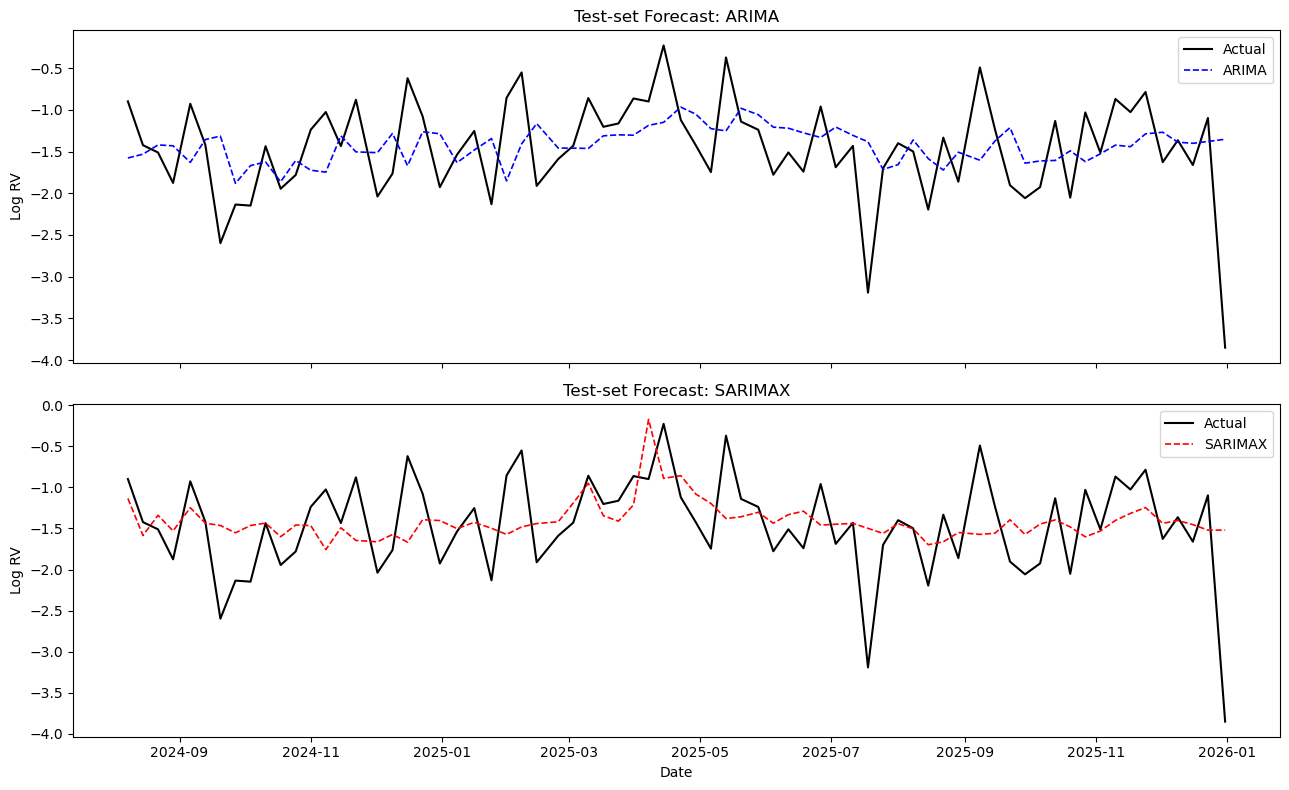

FINAL MODEL SELECTION

Model                               AIC     RMSE      MAE    MAPE%
ARIMA(3,0,3)                     459.33   0.6207   0.4665    43.87
SARIMAX(3,0,3)(0,0,1)_4 [VIX]    403.28   0.5732   0.4241    39.67


In [64]:
# Plotting the forecasts vs actuals for both models

fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

axes[0].plot(test_df['date'].values, test_df['Log_RV'].values, 'k-', label='Actual', linewidth=1.5)
axes[0].plot(test_df['date'].values, preds_arima, 'b--', label="ARIMA", linewidth=1.2)
axes[0].set_ylabel('Log RV')
axes[0].set_title("Test-set Forecast: ARIMA")
axes[0].legend()

axes[1].plot(test_df['date'].values, test_df['Log_RV'].values, 'k-', label='Actual', linewidth=1.5)
axes[1].plot(test_df['date'].values, preds_sarimax, 'r--', label="SARIMAX", linewidth=1.2)
axes[1].set_ylabel('Log RV')
axes[1].set_title("Test-set Forecast: SARIMAX")
axes[1].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.savefig('plot/rolling_forecast.png')
plt.show()

print("FINAL MODEL SELECTION")

metrics = {
    ba['model']: {'RMSE': rmse1, 'MAE': mae1, 'MAPE': mape1, 'AIC': ba['AIC']},
    best_sx_label: {'RMSE': rmse2, 'MAE': mae2, 'MAPE': mape2, 'AIC': best_sarimax_spec['AIC']},
}

print(f"\n{'Model':<30} {'AIC':>8} {'RMSE':>8} {'MAE':>8} {'MAPE%':>8}")
for name, m in metrics.items():
    print(f"{name:<30} {m['AIC']:>8.2f} {m['RMSE']:>8.4f} {m['MAE']:>8.4f} {m['MAPE']:>8.2f}")

In [65]:
# Training and testing R^2 values for the ARIMA(3,0,3) model and the SARIMAX(3,0,3)(0,0,1)_4 [VIX] model

def r_squared(actual, predicted):
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    return 1 - ss_res / ss_tot

train_fitted_arima = res_arima.fittedvalues
train_fitted_sarimax = res_sarimax.fittedvalues

r2_train_arima = r_squared(y_train, train_fitted_arima)
r2_train_sarimax = r_squared(y_train, train_fitted_sarimax)

r2_test_arima = r_squared(y_test, preds_arima)
r2_test_sarimax = r_squared(y_test, preds_sarimax)

print(f"{'':30s} {'Train R²':>12s} {'Test R²':>12s}")
print(f"{'ARIMA(3,0,3)':<30s} {r2_train_arima:>12.4f} {r2_test_arima:>12.4f}")
print(f"{'SARIMAX(3,0,3)(0,0,1)_4 [VIX]':<30s} {r2_train_sarimax:>12.4f} {r2_test_sarimax:>12.4f}")

                                   Train R²      Test R²
ARIMA(3,0,3)                         0.1991      -0.0872
SARIMAX(3,0,3)(0,0,1)_4 [VIX]        0.2314       0.0729
